# **Flooding Metric Analysis Testing**

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from scipy.ndimage import zoom

from model.model import FloodModel

### **Insert the correct paths for the model below**

In [2]:
model_path = './model/resnet18.onnx'
model = FloodModel(model_path, verbose=True)

image_folder = './data/canoas'
no_flood_folder = './data/canoas_no_flood'
output_folder = './data/output_canoas'
no_flood_output_folder = './data/output_canoas_no_flood'

pop_density_path = './data/bra_pd_2020_1km_UNadj.tif'

# Configuration based on the amount of rows and cols of the tiles of Sentinel-1 images
rows = 3
cols = 3

Session initialized: <onnxruntime.capi.onnxruntime_inference_collection.InferenceSession object at 0x74890447dbd0>


Let's test one image to see if the model is working as expected:

In [3]:
output = model.predict(
    os.path.join(image_folder, 'tile_0_0.png'), 
    os.path.join(output_folder, 'tile_0_0.png')
)

Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)


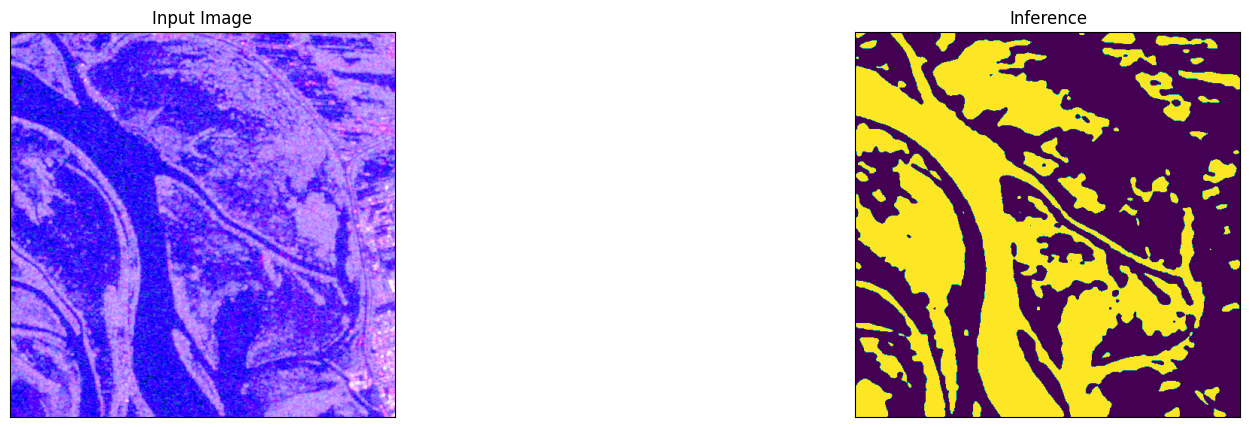

In [4]:
model.plot()

## **Processing all Images**

First, we process the flooded images

In [5]:
for i in range(cols): 
    for j in range(rows): 
        filename = f"tile_{i}_{j}.png"
        model.predict(os.path.join(image_folder, filename), os.path.join(output_folder, filename))

Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)


Then, the images, without flooding for comparisson.

In [6]:
for i in range(cols):
    for j in range(rows):
        filename = f"tile_{i}_{j}.png"
        model.predict(os.path.join(no_flood_folder, filename), os.path.join(no_flood_output_folder, filename))

Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)
Image array shape:  (1, 3, 512, 512)
Shape of the result:  (1, 512, 512, 1)


## **Creating a Map**

We can now visualize all the tiles together and compare the predictions.

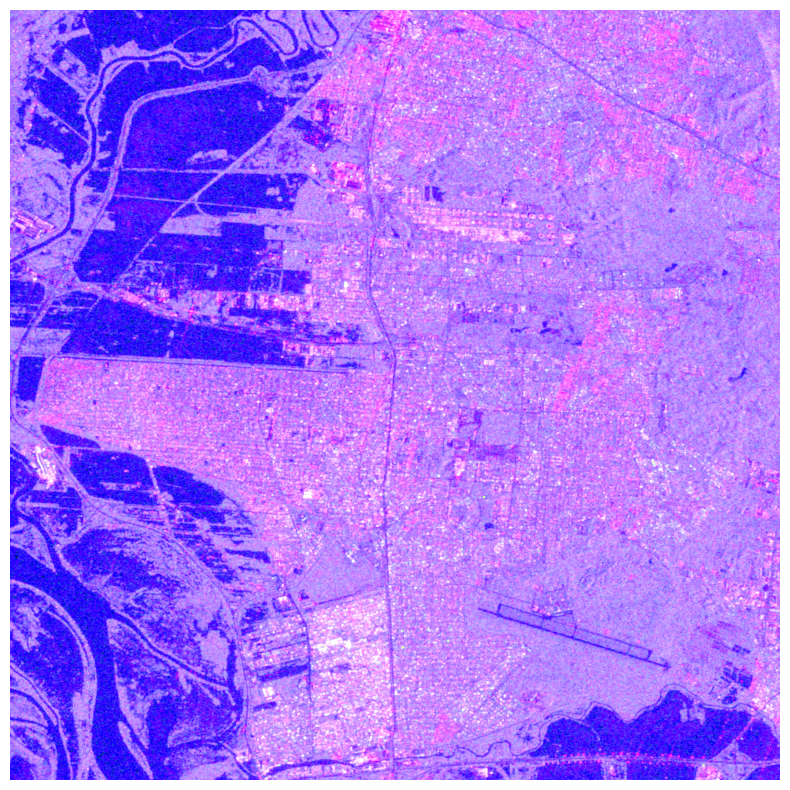

In [8]:
# Load the images into a grid (row-wise)
tiles = []

for i in range(cols):  # Assuming col represents the number of columns
    col_tiles = []
    for j in range(rows):  # Assuming row represents the number of rows
        filename = f"tile_{i}_{j}.png"
        img = Image.open(os.path.join(image_folder, filename))
        col_tiles.append(img)
    tiles.append(col_tiles)

# Get the size of each tile (assuming all tiles are of the same size)
tile_width, tile_height = tiles[0][0].size

# Calculate the total width and height of the stitched image
full_width = rows * tile_width  # Width should be based on columns
full_height = cols * tile_height  # Height should be based on rows

# Create a blank image for the full grid
full_image = Image.new('RGB', (full_width, full_height))  # Use correct width and height

# Paste each row of images into the full image


x_offset = 0
for row_list in tiles:
    row_list.reverse()
    y_offset = 0
    for sing_img in row_list:
        full_image.paste(sing_img, (x_offset, y_offset))
        y_offset += tile_width
    x_offset += tile_height

# Convert the stitched image to a format suitable for plotting
full_image_np = np.array(full_image)

# Plot the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(full_image_np)
plt.axis('off')  # Turn off the axis
plt.show()

Now, creating the map for the outputs

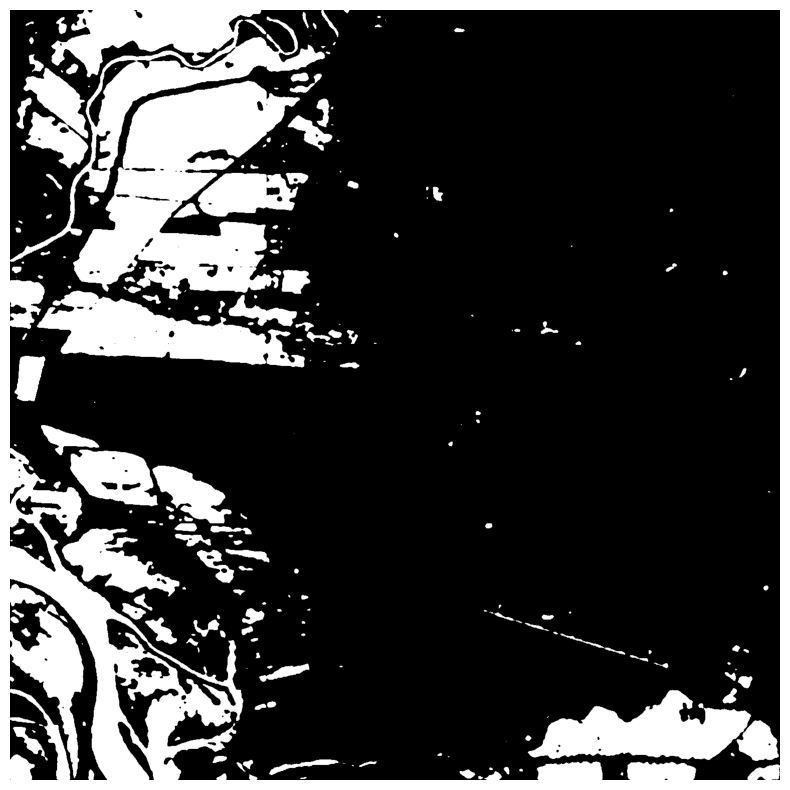

In [9]:
# Load the images into a grid (row-wise)
tiles = []

for i in range(cols):  # Assuming col represents the number of columns
    col_tiles = []
    for j in range(rows):  # Assuming row represents the number of rows
        filename = f"tile_{i}_{j}.png"
        img = Image.open(os.path.join(output_folder, filename))
        col_tiles.append(img)
    tiles.append(col_tiles)

# Get the size of each tile (assuming all tiles are of the same size)
tile_width, tile_height = tiles[0][0].size

# Calculate the total width and height of the stitched image
full_width = rows * tile_width  # Width should be based on columns
full_height = cols * tile_height  # Height should be based on rows

# Create a blank image for the full grid
full_image = Image.new('RGB', (full_width, full_height))  # Use correct width and height

# Paste each row of images into the full image


x_offset = 0
for row_list in tiles:
    row_list.reverse()
    y_offset = 0
    for sing_img in row_list:
        full_image.paste(sing_img, (x_offset, y_offset))
        y_offset += tile_width
    x_offset += tile_height

# Convert the stitched image to a format suitable for plotting
full_image_np = np.array(full_image)

# Plot the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(full_image_np)
plt.axis('off')  # Turn off the axis
plt.show()

## **Mixing the Maps to Analyze Flooding**

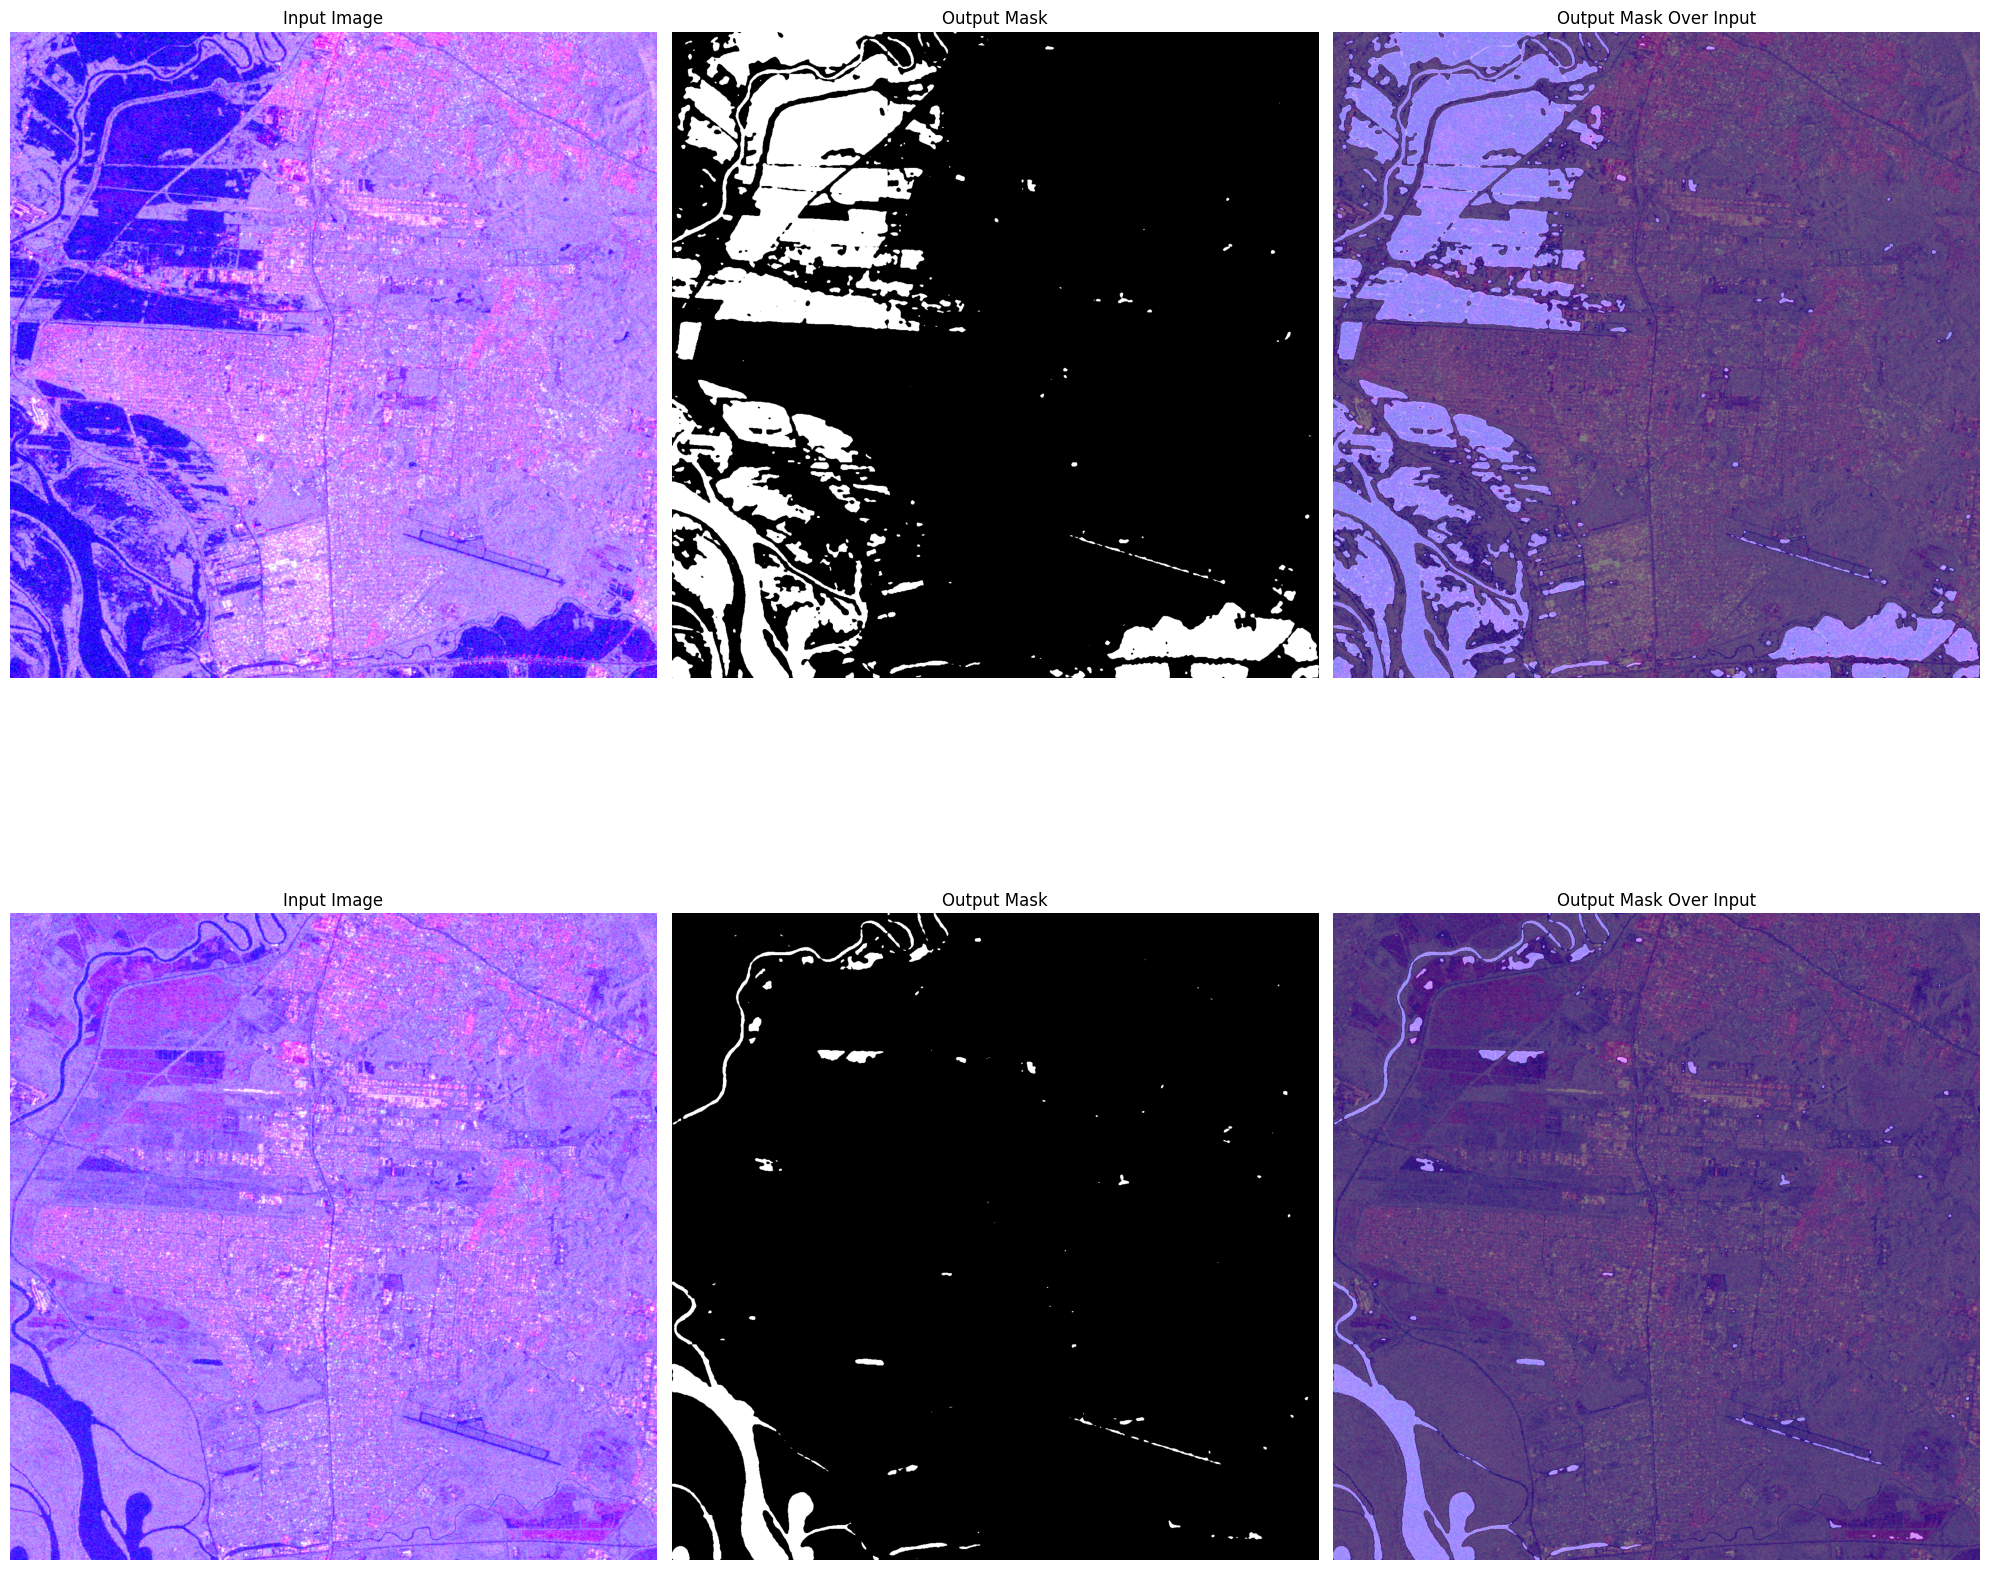

In [10]:
# Function to load images into a grid
def load_tiles(folder_path, rows, cols):
    tiles = []
    for i in range(cols):  # Assuming col represents the number of columns
        col_tiles = []
        for j in range(rows):  # Assuming row represents the number of rows
            filename = f"tile_{i}_{j}.png"
            img = Image.open(os.path.join(folder_path, filename))
            col_tiles.append(img)
        tiles.append(col_tiles)
    return tiles

# Function to stitch the images into a full grid
def stitch_images(tiles, rows, cols):
    tile_width, tile_height = tiles[0][0].size
    full_width = rows * tile_width
    full_height = cols * tile_height
    full_image = Image.new('RGB', (full_width, full_height))
    
    x_offset = 0
    for row_list in tiles:
        row_list.reverse()  # Adjust according to your layout needs
        y_offset = 0
        for sing_img in row_list:
            full_image.paste(sing_img, (x_offset, y_offset))
            y_offset += tile_width
        x_offset += tile_height
    return np.array(full_image)

# Load input and output tiles
input_tiles = load_tiles(image_folder, rows, cols)
output_tiles = load_tiles(output_folder, rows, cols)

# No flood
input_tiles_no_flood = load_tiles(no_flood_folder, rows, cols)
output_tiles_no_flood = load_tiles(no_flood_output_folder, rows, cols)

# Stitch input and output images
input_image_np = stitch_images(input_tiles, rows, cols)
output_image_np = stitch_images(output_tiles, rows, cols)

input_image_np_no_flood = stitch_images(input_tiles_no_flood, rows, cols)
output_image_np_no_flood = stitch_images(output_tiles_no_flood, rows, cols)

# Create a composite image by overlaying the output mask on the input
# For overlay, we assume the output mask is grayscale or has a transparency channel
output_image_overlay = Image.fromarray(output_image_np).convert("RGBA")
input_image_overlay = Image.fromarray(input_image_np).convert("RGBA")
output_image_overlay_no_flood = Image.fromarray(output_image_np_no_flood).convert("RGBA")
input_image_overlay_no_flood = Image.fromarray(input_image_np_no_flood).convert("RGBA")

# Blend the images (adjust the alpha for transparency of the mask)
blended_image = Image.blend(input_image_overlay, output_image_overlay, alpha=0.5)
blended_image_no_flood = Image.blend(input_image_overlay_no_flood, output_image_overlay_no_flood, alpha=0.5)

# Plot the input, output, and composite (overlaid) images
fig, axs = plt.subplots(2, 3, figsize=(20, 20))

# Plot input image
axs[0][0].imshow(input_image_np)
axs[0][0].set_title('Input Image')
axs[0][0].axis('off')

# Plot output image
axs[0][1].imshow(output_image_np)
axs[0][1].set_title('Output Mask')
axs[0][1].axis('off')

# Plot blended image (output mask over input)
axs[0][2].imshow(np.array(blended_image))
axs[0][2].set_title('Output Mask Over Input')
axs[0][2].axis('off')

axs[1][0].imshow(input_image_np_no_flood)
axs[1][0].set_title('Input Image')
axs[1][0].axis('off')

# Plot output image
axs[1][1].imshow(output_image_np_no_flood)
axs[1][1].set_title('Output Mask')
axs[1][1].axis('off')

# Plot blended image (output mask over input)
axs[1][2].imshow(np.array(blended_image_no_flood))
axs[1][2].set_title('Output Mask Over Input')
axs[1][2].axis('off')

plt.tight_layout()
plt.show()

# **Flood Difference**

To be able to measure the impact of the flooding, we will use the approach of subtracting the prediction of the model in images with and without flooding. In this way, we remove the permanent bodies of water of any region.

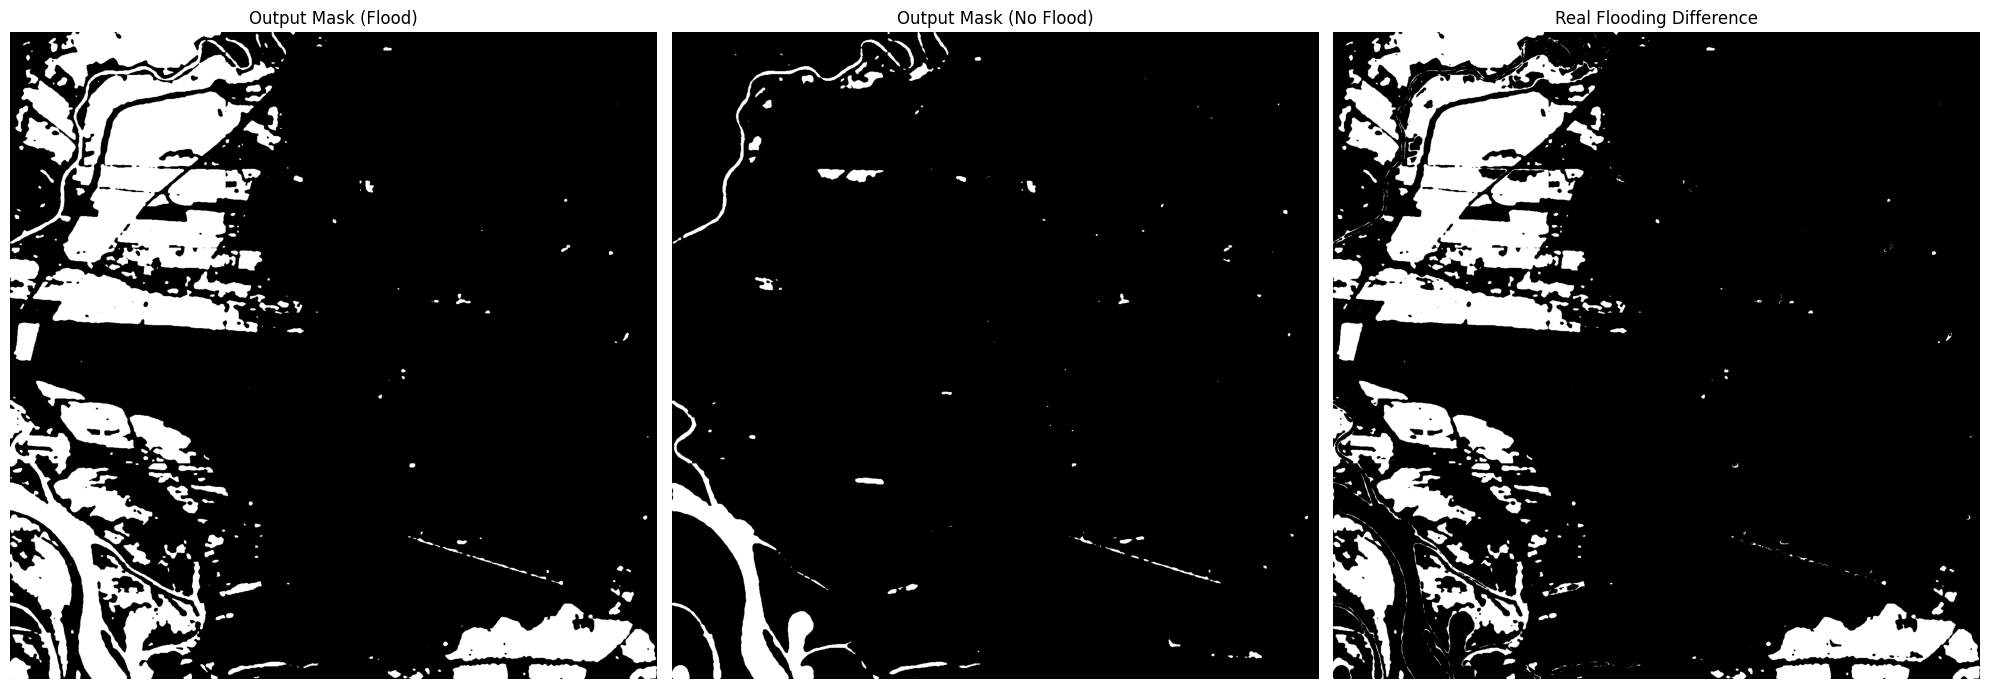

In [8]:
# Subtract the "no flood" mask from the flood mask to get the real flooding areas
flood_difference = np.array(output_image_np, dtype=np.int32) - np.array(output_image_np_no_flood, dtype=np.int32)

# Clip the result to ensure no negative values
flood_difference = np.clip(flood_difference, 0, 255).astype(np.uint8)

# Convert back to an image format for plotting
flood_difference_image = Image.fromarray(flood_difference)

# Plot the output mask (flood), output mask (no flood), and the difference
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Plot output mask with flood
axs[0].imshow(output_image_np, cmap='gray')
axs[0].set_title('Output Mask (Flood)')
axs[0].axis('off')

# Plot output mask with no flood
axs[1].imshow(output_image_np_no_flood, cmap='gray')
axs[1].set_title('Output Mask (No Flood)')
axs[1].axis('off')

# Plot the difference (real flooding areas)
axs[2].imshow(flood_difference_image, cmap='gray')
axs[2].set_title('Real Flooding Difference')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# **Calculating Affected Populatiton**

For this task, we will use a population density map with a 1km/pixel resolution, and expand it to fit our bbox of the map.

In [10]:
# This must be the entire bbox of the stitched image of all tiles! This is achieved by getting
# the northwest corner of the first tile and southeast of the last one.

# Bbox for the Canoas example
minx, miny, maxx, maxy = [-51.245041,-29.971442,-51.1070597725, -29.8334607725]

First, we need to load and zoom in the density map to the desired bbox.

(17, 16)


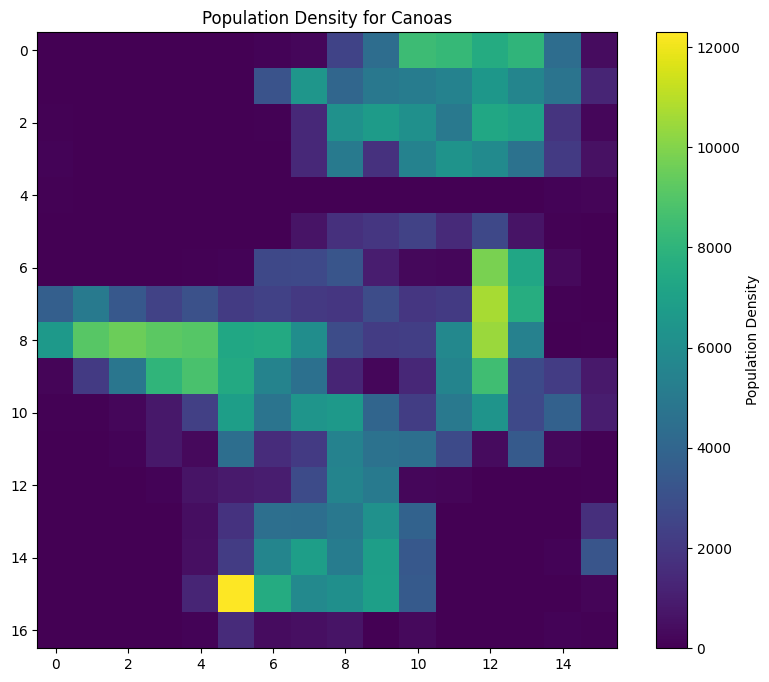

In [21]:
bbox_geom = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox_geom}, index=[0], crs='EPSG:4326')

# Load the population density TIFF file
with rasterio.open(pop_density_path) as src:
    # Reproject the bbox to the same CRS as the population raster
    geo = geo.to_crs(src.crs)
    bbox_geom_proj = [geo.geometry[0]]

    # Clip the population raster to the bbox of Canoas
    out_image, out_transform = mask(src, bbox_geom_proj, crop=True)
    out_meta = src.meta.copy()

    # Update the metadata to match the clipped raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Mask no-data values (use src.nodata to check for no-data values)
    if src.nodata is not None:
        out_image = np.ma.masked_equal(out_image, src.nodata)

    non_zero_rows = np.any(out_image[0] != '--', axis=1)  # Rows that are not all 0
    non_zero_cols = np.any(out_image[0] != '--', axis=0)  # Columns that are not all 0

    # Trim the array to exclude rows and columns that are all 0
    trimmed_image = out_image[0][non_zero_rows, :][:, non_zero_cols]

print(trimmed_image.shape)

# Plot the clipped population density for Canoas
plt.figure(figsize=(10, 8))
plt.imshow(trimmed_image, cmap='viridis')   
plt.colorbar(label='Population Density')
plt.title('Population Density for Canoas')
plt.show()

However, this image is way smaller than our prediction map of all tiles. For that, we will expand the density map averaging the pixel values:

Upscaled population density shape: (1536, 1536)


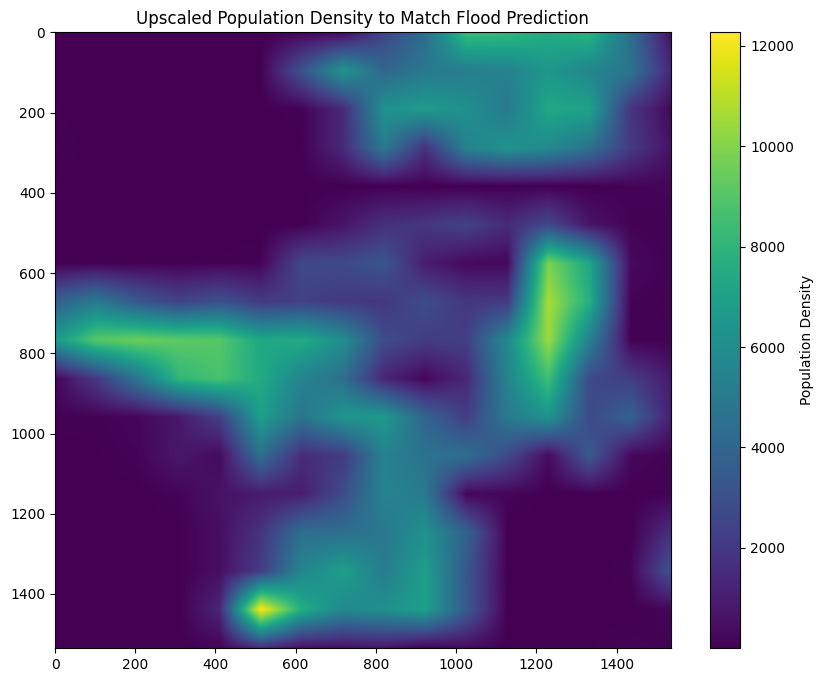

In [22]:
pop_density = np.squeeze(trimmed_image)  # Remove the extra dimension

# Use scipy's zoom function to upscale the population density from (13, 17) to (1536, 1536)
scale_y = full_height / pop_density.shape[0]  # Vertical scale factor
scale_x = full_width / pop_density.shape[1]  # Horizontal scale factor
upscaled_density = zoom(pop_density, (scale_y, scale_x), order=1)  # Bilinear interpolation

print("Upscaled population density shape:", upscaled_density.shape)

# Visualize the upscaled population density
plt.figure(figsize=(10, 8))
plt.imshow(upscaled_density, cmap='viridis')
plt.colorbar(label='Population Density')
plt.title('Upscaled Population Density to Match Flood Prediction')
plt.show()

To calculate the flood mask, we will simply make sure that 1 stays for flooding and 0 stays for no-flooding. Therefore, we can multiply the maps and achieve our final affected population (converting the resolutions from 10m/pixel and 1km/pixel)

In [14]:
flood_mask = np.mean(flood_difference, axis=-1)

flood_mask = flood_mask[:full_height, :full_width]

# Clip the values to ensure it's a binary mask (0 or 1)
flood_mask = np.clip(flood_mask, 0, 1)

print(flood_mask.shape) 

(1536, 1536)


We will divide by 10000 as it is the factor to convert between $100m^2$/pixel and $1000000m^2$/pixel

In [15]:
affected_population = flood_mask * (upscaled_density/10000)

# Sum the total affected population
total_affected_population = np.sum(affected_population)

print(f"Total Estimated Affected Population: {total_affected_population}")

Total Estimated Affected Population: 14656.837285750336


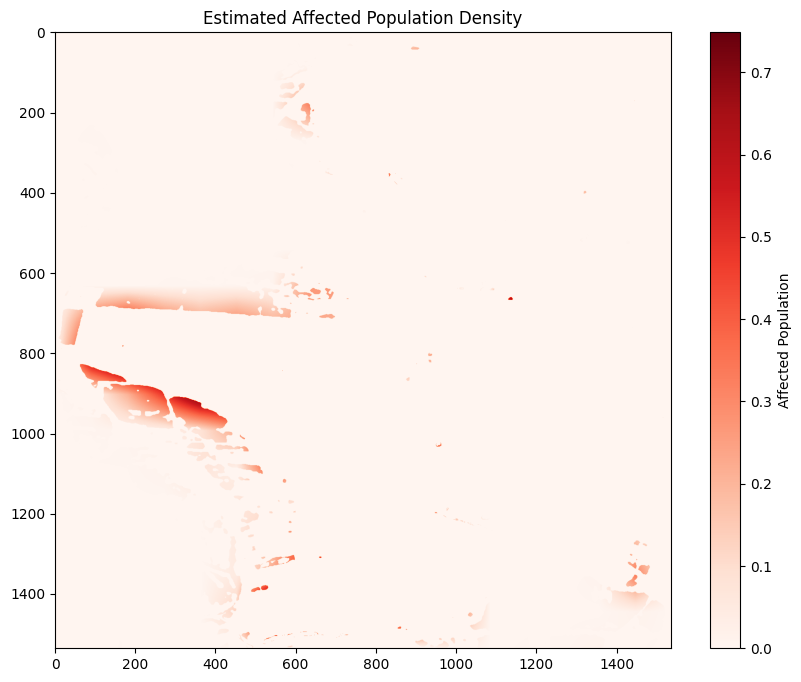

In [16]:

# Plot the affected population density
plt.figure(figsize=(10, 8))
plt.imshow(affected_population, cmap='Reds')
plt.colorbar(label='Affected Population')
plt.title('Estimated Affected Population Density')
plt.show()

Congrats! You reached the end of our experiment :)